# Parker Solar Probe <a class="anchor" id="psp"></a>

## TODO
- Maybe an upper time axis could be a good thing? Or put time axis on each subplot

## Importing and general settings
Only needed to run once

In [ ]:
import astropy.units as u
import datetime as dt
# import math
import numpy as np
import os
import pandas as pd
import warnings

from astropy.constants import e, k_B, m_p
from astropy.table import QTable
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from seppy.loader.psp import calc_av_en_flux_PSP_EPIHI, psp_isois_load
from seppy.tools import resample_df
from stixdcpy.quicklook import LightCurves # https://github.com/i4Ds/stixdcpy
from sunpy.coordinates import frames, get_horizons_coord

from soler.tools.my_func_py3 import mag_angles
from soler.tools.polarity_plotting import polarity_rtn

#import cdaweb
#from PSP import read_psp_fields_cdf

# disable unused speasy data provider before importing to speed it up
os.environ['SPEASY_CORE_DISABLED_PROVIDERS'] = "sscweb,archive,csa"
import speasy as spz

# omit Pandas' PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('axes', titlesize=20)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rcParams['agg.path.chunksize'] = 20000

## Define general options

TODO:
- checklist/dropdown GUI

In [37]:
plot_options = {}

# Timestamp position
pos_timestamp = None

# Path to save data
file_path = f"{os.getcwd()}" + os.sep + "data" 

year = 2022
startdate = dt.datetime(year, 3, 13, 12, 00)
enddate = dt.datetime(year, 3, 15, 12, 00)

plot_rfs = True
plot_stix = True
plot_epilo_e = True
plot_epihi_e = True
plot_epilo_p = True
plot_epihi_p = True
# plot_psp_pixel = True
plot_epihi_p_combined_pixels = True

plot_mag_angles = True 
plot_mag = True
plot_Vsw = True
plot_N = True
plot_T = True
plot_p_dyn = True
plot_polarity = False 

legends_inside = False

resample = "5min"
resample_mag = '1min'

psp_het_viewing = 'A'  # 'A' or 'B'?

epilo_channel = 'F'
epilo_viewing = '3'
epilo_ic_channel = 'T'
epilo_ic_viewing = '3'

stix_ltc = False  # correct SolO/STIX data for light travel time

Don't change the following cell, just run:

In [38]:
if plot_epilo_e or plot_epihi_e:
    plot_electrons = True
else:
    plot_electrons = False

if plot_epilo_p or plot_epihi_p:
    plot_protons = True
else:
    plot_protons = False

panels = 1*plot_rfs + 1*plot_stix + 1*plot_electrons + 1*plot_protons + 2*plot_mag_angles + 1*plot_mag + 1*plot_Vsw + 1*plot_N + 1*plot_T + 1*plot_p_dyn 

panel_ratios = list(np.zeros(panels)+1)

if plot_rfs:
    panel_ratios[0] = 2

if plot_electrons and plot_protons:
    panel_ratios[0+1*plot_stix+1*plot_rfs] = 2
    panel_ratios[1+1*plot_stix+1*plot_rfs] = 2
if plot_electrons or plot_protons:    
    panel_ratios[0+1*plot_stix+1*plot_rfs] = 2



## Data loading

### Load SolO/STIX data

In [39]:
if plot_stix:
    if enddate-startdate > dt.timedelta(days=7):
        print('WARNING: STIX loading for more than 7 days not supported at the moment!')
        print('')
    lc = LightCurves.from_sdc(start_utc=startdate, end_utc=enddate, ltc=stix_ltc)
    df_stix_orig = lc.to_pandas()

### Load PSP data

In [40]:
# NOT IN USE HERE: Manual loading of private data

# psp_man_path = 'psp_private_data/'

# df_psp_pixel_org = pd.DataFrame()
# for key in ['L2Ap', 'L3Ap', 'L4Ap', 'H2Ap', 'H3Ap', 'H4Ap']:
#     tdf = pd.read_csv(psp_man_path+f'{key}_flux60_full.csv', skiprows=25, date_format='%Y-%jT%H:%M:%S.%f', index_col=0, names=[f'{key}_Flux'])
#     df_psp_pixel_org = pd.concat([df_psp_pixel_org, tdf], axis=1)

# energies_psp_pixel = {}
# energies_psp_pixel['L2Ap'] = '5.22 - 12.20 MeV'
# energies_psp_pixel['L3Ap'] = '11.49 - 20.76 MeV'
# energies_psp_pixel['H2Ap'] = '12.95 - 18.08 MeV'
# energies_psp_pixel['L4Ap'] = '17.63 - 26.35 MeV'
# energies_psp_pixel['H3Ap'] = '23.65 - 27.53 MeV'
# energies_psp_pixel['H4Ap'] = '31.04 - 36.19 MeV'

In the following, loading of public level-2 data

In [41]:
df_psp_het_org, psp_het_energies = psp_isois_load('PSP_ISOIS-EPIHI_L2-HET-RATES60', startdate, enddate, path=None, resample=None)

2025-03-05 11:37:51 - sunpy - WARNING: SunpyUserWarning: The variable "HET_A_R17_SECT_HCI" has been skipped because it has more than 2 dimensions, which is unsupported.
2025-03-05 11:37:51 - sunpy - WARNING: SunpyUserWarning: The variable "HET_A_R17_SECT_RTN" has been skipped because it has more than 2 dimensions, which is unsupported.
2025-03-05 11:37:51 - sunpy - WARNING: SunpyUserWarning: The variable "HET_B_R17_SECT_HCI" has been skipped because it has more than 2 dimensions, which is unsupported.
2025-03-05 11:37:51 - sunpy - WARNING: SunpyUserWarning: The variable "HET_B_R17_SECT_RTN" has been skipped because it has more than 2 dimensions, which is unsupported.
2025-03-05 11:37:52 - sunpy - WARNING: SunpyUserWarning: The variable "HET_A_R17_SECT_HCI" has been skipped because it has more than 2 dimensions, which is unsupported.
2025-03-05 11:37:52 - sunpy - WARNING: SunpyUserWarning: The variable "HET_A_R17_SECT_RTN" has been skipped because it has more than 2 dimensions, which is

In [42]:
df_psp_epilo_org, psp_epilo_energies_org = psp_isois_load('PSP_ISOIS-EPILO_L2-PE', startdate, enddate, path=None, resample=None, epilo_channel=epilo_channel, epilo_threshold=None)

In [43]:
df_psp_epilo_ic_org, psp_epilo_ic_energies_org = psp_isois_load('PSP_ISOIS-EPILO_L2-IC', startdate, enddate, path=None, resample=None, epilo_channel=epilo_ic_channel, epilo_threshold=None)

In [44]:
# for i in range(47):
#     print(f'H_Chan{epilo_ic_channel}_Energy_E{i}_P{epilo_ic_viewing}', psp_epilo_ic_energies_org[f'H_Chan{epilo_ic_channel}_Energy'][f'H_Chan{epilo_ic_channel}_Energy_E{i}_P{epilo_ic_viewing}'])

In [45]:
# FIELDS/RFS

# psp_rfs_lfr, psp_rfs_hfr = read_psp_fields_cdf(startdate, enddate)
# df_psp_rfs_lfr = pd.DataFrame(psp_rfs_lfr)
# df_psp_rfs_hfr = pd.DataFrame(psp_rfs_hfr)

psp_rfs_lfr_psd = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSP_FLD.RFS_LFR.PSP_FLD_L3_RFS_LFR.psp_fld_l3_rfs_lfr_PSD_SFU,
                                startdate, enddate).replace_fillval_by_nan()
psp_rfs_hfr_psd = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSP_FLD.RFS_HFR.PSP_FLD_L3_RFS_HFR.psp_fld_l3_rfs_hfr_PSD_SFU, 
                                startdate, enddate).replace_fillval_by_nan()

# Get frequency bins, since metadata is lost upon conversion to df
psp_rfs_lfr_freq = psp_rfs_lfr_psd.axes[1].values[0] / 1e6  # in MHz
psp_rfs_hfr_freq = psp_rfs_hfr_psd.axes[1].values[0] / 1e6

df_psp_rfs_lfr_psd_o = psp_rfs_lfr_psd.to_dataframe()
df_psp_rfs_hfr_psd_o = psp_rfs_hfr_psd.to_dataframe()

# put frequencies into column names for easier access
df_psp_rfs_lfr_psd_o.columns = psp_rfs_lfr_freq
df_psp_rfs_hfr_psd_o.columns = psp_rfs_hfr_freq

# SPC
df_psp_spc_np_tot = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_np_tot, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_spc_vp_tot_nrm = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_vp_tot_nrm, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_spc_vp_tot_rtn = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_vp_tot, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_spc_wp_tot = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_wp_tot, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_spc_GF = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_flag.psp_spc_gf, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_spc = pd.concat([df_psp_spc_np_tot, df_psp_spc_vp_tot_nrm, df_psp_spc_vp_tot_rtn, df_psp_spc_wp_tot, df_psp_spc_GF], axis=1)

# SPAN-i
df_psp_spani_np = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.DENS, 
                            startdate, enddate).replace_fillval_by_nan().to_dataframe()
df_psp_spani_vp_rtn_sun = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.VEL_RTN_SUN, 
                            startdate, enddate).replace_fillval_by_nan().to_dataframe()
df_psp_spani_T = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.TEMP, 
                            startdate, enddate).replace_fillval_by_nan().to_dataframe()
df_psp_spani_QF = spz.get_data(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.QUALITY_FLAG, 
                            startdate, enddate).replace_fillval_by_nan().to_dataframe()
df_psp_spani = pd.concat([df_psp_spani_np, df_psp_spani_vp_rtn_sun, df_psp_spani_T, df_psp_spani_QF], axis=1)

# MAG
df_psp_mag_rtn = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.FIELDS_MAG.psp_mag_1min.psp_b_1min, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_mag_phi = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.FIELDS_MAG.psp_mag_1min.psp_b_1min_phi, 
                           startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_mag_theta = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.FIELDS_MAG.psp_mag_1min.psp_b_1min_theta, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_mag_tot = spz.get_data(spz.inventories.data_tree.amda.Parameters.PSP.FIELDS_MAG.psp_mag_1min.psp_b_1min_tot, 
                            startdate, enddate, output_format="CDF_ISTP").replace_fillval_by_nan().to_dataframe()
df_psp_mag = pd.concat([df_psp_mag_rtn, df_psp_mag_phi, df_psp_mag_theta, df_psp_mag_tot], axis=1)
df_psp_mag['phi_mod'] = ((df_psp_mag['phi'].values - 180) % 360) - 180 



c:\Users\osant\miniforge3\envs\sp2\Lib\site-packages\speasy\core\data_containers.py:17: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.searchsorted(time, np.datetime64(key, 'ns'), side='left')
c:\Users\osant\miniforge3\envs\sp2\Lib\site-packages\speasy\core\data_containers.py:17: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.searchsorted(time, np.datetime64(key, 'ns'), side='left')
c:\Users\osant\miniforge3\envs\sp2\Lib\site-packages\speasy\core\data_containers.py:17: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.searchsorted(time, np.datetime64(key, 'ns'), side='left')


In [46]:
if plot_mag_angles:
    theta, phi = mag_angles(df_psp_mag['|b|'].values, df_psp_mag['br'].values, df_psp_mag['bt'].values, df_psp_mag['bn'].values)
    df_psp_mag['theta2'] = theta
    df_psp_mag['phi2'] = phi

#### Convert to Astropy QTable
Read units into dictionary

In [47]:
df_psp_spc_units = {}
df_psp_spc_units['np_tot'] = u.Unit(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_np_tot.units)
df_psp_spc_units['|vp_tot|'] = u.Unit(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_vp_tot_nrm.units)
for k in ['vp_totr', 'vp_tott', 'vp_totn']:
    df_psp_spc_units[k] = u.Unit(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_vp_tot.units)
df_psp_spc_units['wp_tot'] = u.Unit(spz.inventories.data_tree.amda.Parameters.PSP.SWEAP_SPC.psp_spc_fit.psp_spc_wp_tot.units)

df_psp_spani_units = {}
df_psp_spani_units['Density'] = u.Unit(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.DENS.UNITS)
for k in ['Vx RTN', 'Vy RTN', 'Vz RTN']:
    df_psp_spani_units[k] = u.Unit(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.VEL_RTN_SUN.UNITS)
df_psp_spani_units['Temperature'] = u.Unit(spz.inventories.data_tree.cda.ParkerSolarProbe.PSPSWEAPSPAN.PSP_SWP_SPI_SF00_L3_MOM.TEMP.UNITS)

In [48]:
qt_psp_spc = QTable.from_pandas(df_psp_spc, index=True, units=df_psp_spc_units)
# qt_psp_spc = QTable(qt_psp_spc, masked=True)

In [49]:
qt_psp_spani = QTable.from_pandas(df_psp_spani, index=True, units=df_psp_spani_units)

In [50]:
qt_psp_spc['T'] = (1/2*m_p/k_B*(qt_psp_spc['wp_tot'])**2).si
qt_psp_spc['p_dyn'] = (m_p*qt_psp_spc['np_tot']*(qt_psp_spc['|vp_tot|'])**2).to(u.nPa)

In [51]:
qt_psp_spani['V_tot_rtn'] = np.sqrt(qt_psp_spani['Vx RTN']**2+qt_psp_spani['Vy RTN']**2+qt_psp_spani['Vz RTN']**2)
qt_psp_spani['T_K'] = (qt_psp_spani['Temperature']/k_B).si
qt_psp_spani['p_dyn'] = (m_p*qt_psp_spani['Density']*(qt_psp_spani['V_tot_rtn'])**2).to(u.nPa)

In [52]:
qt_psp_spc

index,np_tot,|vp_tot|,vp_totr,vp_tott,vp_totn,wp_tot,general_flag,T,p_dyn
,1 / cm3,km / s,km / s,km / s,km / s,km / s,,K,nPa
Time,float64,float64,float64,float64,float64,float64,float64,float64,float64
2022-03-13T12:00:04.104,12.28852653503418,566.219482421875,562.3922119140625,-24.00792694091797,61.18087387084961,95.07872772216797,1.0,547584.6052828312,6.589723820892559
2022-03-13T12:00:32.066,13.355278015136719,563.8363647460938,558.4305419921875,-42.999393463134766,64.9451904296875,107.55241394042969,1.0,700688.2441687522,7.101611052166438
2022-03-13T12:01:00.028,12.277624130249023,559.435791015625,554.154052734375,-17.806053161621094,74.59638977050781,90.28966522216797,1.0,493810.80915600184,6.427063845765145
2022-03-13T12:01:27.990,12.846393585205078,560.3442993164062,554.5697631835938,-21.45649528503418,77.31571960449219,95.98143768310547,1.0,558031.8770126251,6.746661558380076
2022-03-13T12:01:55.952,14.855741500854492,562.6768798828125,550.3845825195312,-36.22257995605469,111.22059631347656,109.04438018798828,1.0,720262.9628456437,7.867020102144499
2022-03-13T12:02:23.914,———,———,———,———,———,———,1.0,———,———
2022-03-13T12:02:51.876,11.46720027923584,551.65966796875,550.450927734375,-18.91051483154297,31.218585968017578,85.31535339355469,1.0,440898.77757233917,5.8371069409783765
2022-03-13T12:03:19.838,11.855178833007812,551.5526733398438,550.895263671875,-11.894904136657715,24.151460647583008,85.56389617919922,1.0,443471.39374973334,6.032257643780124


In [53]:
qt_psp_spani

index,Density,Vx RTN,Vy RTN,Vz RTN,Temperature,Quality Flag,V_tot_rtn,T_K,p_dyn
,1 / cm3,km / s,km / s,km / s,eV,,km / s,K,nPa
Time,float64,float64,float64,float64,float64,float64,float64,float64,float64
2022-03-13T12:03:04.984,1.9866900444030762,541.1610717773438,-88.92623901367188,-22.08872413635254,58.70344924926758,4288.0,548.8634559945597,681225.2406106212,1.001051756911229
2022-03-13T12:06:48.680,1.8843294382095337,529.5556030273438,-81.93296813964844,-30.813547134399414,51.70249557495117,4288.0,536.7416721783676,599982.5468288838,0.9079987437788505
2022-03-13T12:10:32.377,1.718558669090271,528.3572998046875,-79.9967041015625,-33.46979522705078,50.971435546875,4288.0,535.4261257321631,591498.9474851328,0.8240646124440172
2022-03-13T12:14:16.074,1.6759012937545776,538.4901123046875,-83.26131439208984,-30.824169158935547,56.902923583984375,4288.0,545.7601826155441,660331.0078995262,0.834929711437793
2022-03-13T12:17:59.770,1.8408280611038208,544.4762573242188,-86.78337860107422,-28.404300689697266,57.96009826660156,4288.0,552.0802060288677,672599.0106616012,0.9384591301670442
2022-03-13T12:21:43.467,1.5405486822128296,543.4205932617188,-88.07418060302734,-26.462711334228516,62.73393630981445,4288.0,551.1472376425121,727997.1007434104,0.782723696268969
2022-03-13T12:25:27.164,1.3202406167984009,561.8765258789062,-97.3052978515625,-24.861404418945312,66.69696807861328,4288.0,570.7816051288031,773986.1747207151,0.7194337563678502
2022-03-13T12:29:10.861,1.4126245975494385,561.0615844726562,-99.27777862548828,-19.38581657409668,63.9595947265625,4288.0,570.1069976627401,742220.2760513936,0.7679576881468279


In [54]:
df_psp_spc = qt_psp_spc.to_pandas(index='index')
df_psp_spc.index.name = None

In [55]:
df_psp_spani = qt_psp_spani.to_pandas(index='index')
df_psp_spani.index.name = None

Some SPAN-i temperature values are negative. Check this and clean the data afterwards

14.262001037597656
165503.64949036806


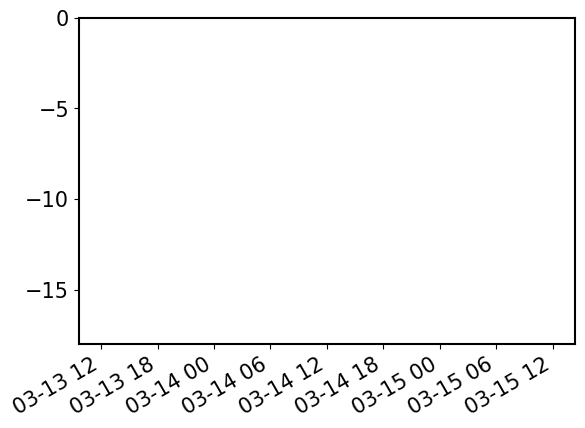

In [56]:
try:
    print(np.nanmin(df_psp_spani['Temperature']))
    print(np.nanmin(df_psp_spani['T_K']))
    df_psp_spani['T_K'].plot()
    df_psp_spani['Temperature'].plot()
    plt.ylim(-18.002, 0.0)
    plt.show()
except:
    print('not possible. no data?')

#### clean data

In [57]:
if plot_epilo_e:
    electron_countrate_keys = df_psp_epilo_org.filter(like='Electron_CountRate_ChanF_E').keys()
    df_psp_epilo_org[electron_countrate_keys] = df_psp_epilo_org[electron_countrate_keys].mask(df_psp_epilo_org[electron_countrate_keys] < 0.0)

In [70]:
df_psp_spc = df_psp_spc.mask(df_psp_spc['general_flag']!=0.0)

In [72]:
df_psp_spani['Temperature'] = df_psp_spani['Temperature'].mask(df_psp_spani['Temperature']<0.0)
df_psp_spani['Temperature'] = df_psp_spani['T_K'].mask(df_psp_spani['T_K']<0.0)

In [60]:
# gf_mask = qt_psp_spc['general_flag']!=0.0
# for key in qt_psp_spc.columns.keys():
#     if key != 'index':
#         qt_psp_spc[key].mask = gf_mask

In [61]:
# SPAN-I
# df_psp_spani_vp_rtn_sun['V_tot_rtn'] = np.sqrt(df_psp_spani_vp_rtn_sun['Vx RTN']**2+df_psp_spani_vp_rtn_sun['Vy RTN']**2+df_psp_spani_vp_rtn_sun['Vz RTN']**2)

# df_psp_spani_T['T_K'] = df_psp_spani_T['Temperature']/k_B.value*e.value
# df_psp_spani_T['T_1000K'] = df_psp_spani_T['Temperature']/k_B.value*e.value/1000

# df_psp_spani = pd.concat([df_psp_spani_np, df_psp_spani_vp_rtn_sun, df_psp_spani_T, df_psp_spani_QF], axis=1)

#### Filter data based on Quality Flags
The Quality flags mostly contain a description of the instrument activities and operational status. For those, I would recommend avoiding anything with the following quality bits set to 1:

- bit0 - counter overflow
- bit3 - spoiler test
- bit10 - bad energy table
- bit11 - MCP test
- bit14 - threshold test
- bit15 - commanding

(R. Livi, priv. comm.)

In [62]:
df_psp_spani['Quality Flag binary'] = df_psp_spani['Quality Flag'].astype(int).map('{:b}'.format).astype(str)
df_psp_spani['Quality Flag binary'] = df_psp_spani['Quality Flag binary'].str.zfill(16)

qf_bits_list = ['Counter Overflow', 'Survey Snapshot ON (not applicable to archive products)', 'Alternate Energy Table', 'Spoiler Test', 'Attenuator Engaged', 'Highest Archive Rate', 'No Targeted Sweep',
                'SPAN-Ion New Mass Table (not applicable to electrons)', 'Over-deflection', 'Archive Snapshot ON', 'Bad Energy Table', 'MCP Test', 'Survey Available', 'Archive Available', 
                'Threshold Test', 'Commanding']
qf_bits_list.reverse()

for i in range(len(qf_bits_list)):
    df_psp_spani[qf_bits_list[i]] = df_psp_spani['Quality Flag binary'].str[i]
    df_psp_spani[qf_bits_list[i]] = df_psp_spani[qf_bits_list[i]].astype(int)

cond1 = df_psp_spani['Counter Overflow']==1
cond2 = df_psp_spani['Spoiler Test']==1
cond3 = df_psp_spani['Bad Energy Table']==1
cond4 = df_psp_spani['MCP Test']==1
cond5 = df_psp_spani['Threshold Test']==1
cond6 = df_psp_spani['Commanding']==1

df_psp_spani = df_psp_spani.mask(cond1 | cond2 | cond3 | cond4 | cond5 | cond6)

Drop binary version of Quality Flag because otherwise resampling will crash later:

In [63]:
df_psp_spani.drop(columns='Quality Flag binary', inplace=True)

## Resampling of loaded data

In [64]:
if resample is not None:
    if plot_epihi_e or plot_epihi_p:
        df_psp_het = resample_df(df_psp_het_org, resample)   
    if plot_epilo_e:
        df_psp_epilo = resample_df(df_psp_epilo_org, resample) 
    if plot_epilo_p:
        df_psp_epilo_ic = resample_df(df_psp_epilo_ic_org, resample) 
    # if plot_psp_pixel:
    #     df_psp_pixel = resample_df(df_psp_pixel_org, resample) 
    if plot_Vsw or plot_N or plot_T:
        df_magplas_spani = resample_df(df_psp_spani, resample_mag) 
        df_magplas_spc = resample_df(df_psp_spc, resample_mag)
    if plot_mag:
        df_mag = resample_df(df_psp_mag, resample_mag) 
    if plot_stix:
        df_stix = resample_df(df_stix_orig, resample)
    if plot_rfs:
        df_psp_rfs_hfr_psd = resample_df(df_psp_rfs_hfr_psd_o, resample, origin="start_day")
        df_psp_rfs_lfr_psd = resample_df(df_psp_rfs_lfr_psd_o, resample, origin="start_day")
        
else:
    if plot_epihi_e or plot_epihi_p:
        df_psp_het = df_psp_het_org 
    if plot_epilo_e:
        df_psp_epilo = df_psp_epilo_org
    if plot_epilo_p:
        df_psp_epilo_ic = df_psp_epilo_ic_org
    # if plot_psp_pixel:
    #     df_psp_pixel = df_psp_pixel_org
    if plot_Vsw or plot_N or plot_T:
        df_magplas_spani = df_psp_spani 
        df_magplas_spc = df_psp_spc
    if plot_mag:
        df_mag = df_psp_mag
    if plot_stix:
        df_stix = df_stix_orig
    if plot_rfs:
        df_psp_rfs_hfr_psd = df_psp_rfs_hfr_psd_o
        df_psp_rfs_lfr_psd = df_psp_rfs_lfr_psd_o
        # Remove bar artifacts caused by non-NaN values before time jumps
        for i in range(len(df_psp_rfs_lfr_psd.index) - 1):
            if (df_psp_rfs_lfr_psd.index[i+1] - df_psp_rfs_lfr_psd.index[i]) > np.timedelta64(5, "m"):   
                df_psp_rfs_lfr_psd.iloc[i,:] = np.nan
        for i in range(len(df_psp_rfs_hfr_psd.index) - 1):
            if (df_psp_rfs_hfr_psd.index[i+1] - df_psp_rfs_hfr_psd.index[i]) > np.timedelta64(5, "m"):
                df_psp_rfs_hfr_psd.iloc[i,:] = np.nan


## Energy channel selection

In [65]:
#Choose every n:th channel
n_psp_het_e = 2
n_psp_het_p = 2
n_psp_epilo_e = 1
n_psp_epilo_ic = 4

#Channels list
channels_n_psp_het_e = list(np.arange(0, len(df_psp_het.filter(like=f'{psp_het_viewing}_Electrons_Rate_').keys()), n_psp_het_e))
channels_n_psp_het_p = list(np.arange(0, len(df_psp_het.filter(like=f'{psp_het_viewing}_H_Flux_').keys()), n_psp_het_p))
channels_n_psp_epilo_e = list(np.arange(3, 8, n_psp_epilo_e)) # list(np.arange(0, len(df_psp_epilo.filter(like='Electron_CountRate_ChanF').keys()), n_psp_epilo_e))
channels_n_psp_epilo_ic = list(np.arange(0, 31, n_psp_epilo_ic))

# channels_n_psp_epilo_e = [ 10, 11]
# channels_n_psp_epilo_ic = []
# channels_n_psp_het_e = [0, 1, 2]

#Chosen channels
print('Channels:')
print('psp_het_e:', channels_n_psp_het_e, ',', len(channels_n_psp_het_e))
print('psp_het_p:', channels_n_psp_het_p, ',', len(channels_n_psp_het_p))
print('psp_epilo_e:', channels_n_psp_epilo_e, ',', len(channels_n_psp_epilo_e))
print('psp_epilo_ic:', channels_n_psp_epilo_ic, ',', len(channels_n_psp_epilo_ic))

Channels:
psp_het_e: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18)] , 10
psp_het_p: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(14)] , 8
psp_epilo_e: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)] , 5
psp_epilo_ic: [np.int64(0), np.int64(4), np.int64(8), np.int64(12), np.int64(16), np.int64(20), np.int64(24), np.int64(28)] , 8


In [66]:
print(f'HET {psp_het_viewing}'+psp_het_energies['H_ENERGY_LABL'][0][0])
print(df_psp_het[f'{psp_het_viewing}_H_Flux_0'].sum())

HET A 
0.0


In [67]:
def make_plot():
    font_ylabel = 20
    font_legend = 10
    
    if panels == 3:
        fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 4*panels])#, gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
    else:
        fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 3*panels], gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
    fig.subplots_adjust(hspace=0.1)
    
    i = 0

    if plot_rfs:
        vmin, vmax = 500, 1e7
        log_norm = LogNorm(vmin=vmin, vmax=vmax)
        
        TimeHFR2D, FreqHFR2D = np.meshgrid(df_psp_rfs_hfr_psd.index, df_psp_rfs_hfr_psd.columns, indexing='ij')
        TimeLFR2D, FreqLFR2D = np.meshgrid(df_psp_rfs_lfr_psd.index, df_psp_rfs_lfr_psd.columns, indexing='ij')

        # Create colormeshes. Shading option flat and thus the removal of last row and column are there to solve the time jump bar problem, 
        # when resampling isn't used
        mesh = axs[i].pcolormesh(TimeLFR2D, FreqLFR2D, df_psp_rfs_lfr_psd.iloc[:-1,:-1], shading='flat', cmap='jet', norm=log_norm)
        axs[i].pcolormesh(TimeHFR2D, FreqHFR2D, df_psp_rfs_hfr_psd.iloc[:-1,:-1], shading='flat', cmap='jet', norm=log_norm) # TODO: check if on top

        axs[i].set_yscale('log')
        axs[i].set_ylabel("Frequency (MHz)", fontsize=font_ylabel)
        
        # Add inset axes for colorbar
        axins = inset_axes(axs[i], width="100%", height="100%", loc="center", bbox_to_anchor=(1.05,0,0.03,1), bbox_transform=axs[i].transAxes, borderpad=0.2)
        cbar = fig.colorbar(mesh, cax=axins, orientation="vertical")
        cbar.set_label("Intensity (sfu)", rotation=90, labelpad=10, fontsize=font_ylabel)
        i += 1
        
    
    if plot_stix:
        for key in df_stix.keys():
            axs[i].plot(df_stix.index, df_stix[key], ds="steps-mid", label=key)
        if stix_ltc:
            title = 'SolO/STIX (light travel time corrected)'
        else:
            title = 'SolO/STIX'
        if legends_inside:
            axs[i].legend(loc='upper right', title=title)
        else:
            # axs[i].legend(loc='upper right', title=title, bbox_to_anchor=(1, 0.5))
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left', title=title)
        axs[i].set_ylabel('Counts', fontsize=font_ylabel)
        axs[i].set_yscale('log')
        i +=1  
    
    
    color_offset = 4 
    
    if plot_electrons:
        if plot_epilo_e:
            axs[i].set_prop_cycle('color', plt.cm.viridis_r(np.linspace(0, 1, len(channels_n_psp_epilo_e)+color_offset)))
            for channel in channels_n_psp_epilo_e:
                psp_epilo_energy = np.round(psp_epilo_energies_org[f'Electron_Chan{epilo_channel}_Energy'][f'Electron_Chan{epilo_channel}_Energy_E{channel}_P{epilo_viewing}'], 2).astype(str)
                axs[i].plot(df_psp_epilo.index, df_psp_epilo[f'Electron_CountRate_Chan{epilo_channel}_E{channel}_P{epilo_viewing}'],
                            ds="steps-mid", label=f'EPI-lo PE {epilo_channel}{epilo_viewing} {psp_epilo_energy} keV')
    
        if plot_epihi_e:
            axs[i].set_prop_cycle('color', plt.cm.Reds_r(np.linspace(0, 1, len(channels_n_psp_het_e)+color_offset)))
            for channel in channels_n_psp_het_e:
                axs[i].plot(df_psp_het.index, df_psp_het[f'{psp_het_viewing}_Electrons_Rate_{channel}'],
                            ds="steps-mid", label=f'HET {psp_het_viewing}'+psp_het_energies['Electrons_ENERGY_LABL'].flatten()[channel])
                
        # axs[i].set_ylabel("Flux\n"+r"[(cm$^2$ sr s MeV)$^{-1}]$", fontsize=font_ylabel)
        axs[i].set_ylabel("Count rates", fontsize=font_ylabel)
        if legends_inside:
            axs[i].legend(loc='upper right', borderaxespad=0., 
                          title=f'Electrons',
                          fontsize=font_legend)
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., 
                          title=f'Electrons',
                          fontsize=font_legend)
       
        axs[i].set_yscale('log')
        i +=1    
    
        
    color_offset = 2    
    if plot_protons:
        if plot_epilo_p:
            axs[i].set_prop_cycle('color', plt.cm.viridis_r(np.linspace(0, 1, len(channels_n_psp_epilo_ic)+color_offset)))
            # [::-1] to reverse list
            for channel in channels_n_psp_epilo_ic[::-1]:
                # print(f'H_Flux_Chan{epilo_ic_channel}_E{channel}_P{epilo_ic_viewing}')
                psp_epilo_ic_energy = np.round(psp_epilo_ic_energies_org[f'H_Chan{epilo_ic_channel}_Energy'][f'H_Chan{epilo_ic_channel}_Energy_E{channel}_P{epilo_ic_viewing}'], 2).astype(str)
                axs[i].plot(df_psp_epilo_ic.index, df_psp_epilo_ic[f'H_Flux_Chan{epilo_ic_channel}_E{channel}_P{epilo_ic_viewing}'],
                            ds="steps-mid", label=f'EPI-lo IC {epilo_ic_channel}{epilo_ic_viewing} {psp_epilo_ic_energy} keV')
    
        # if plot_psp_pixel:
        #     axs[i].set_prop_cycle('color', plt.cm.tab10(range(6)))
        #     for key in ['L2Ap', 'L3Ap', 'L4Ap', 'H2Ap', 'H3Ap', 'H4Ap']:
        #     # for key in ['L2Ap', 'L4Ap', 'H2Ap', 'H3Ap', 'H4Ap']:
        #         axs[i].plot(df_psp_pixel.index, df_psp_pixel[f'{key}_Flux'], label=f'{key} {energies_psp_pixel[key]}', drawstyle='steps-mid')
        
        if plot_epihi_p:    
            if plot_epihi_p_combined_pixels:
                # comb_channels = [[1,2], [3,5], [5,7], [4,5], [7], [9]]
                comb_channels = [[3,5], [5,7], [4,5], [7], [9]]
                axs[i].set_prop_cycle('color', plt.cm.Greys_r(np.linspace(0, 1, len(comb_channels)+5)))
                for channel in comb_channels:
                    df_psp_epihi, df_psp_epihi_name = calc_av_en_flux_PSP_EPIHI(df_psp_het, psp_het_energies, channel, 'p', 'het', psp_het_viewing)
                    axs[i].plot(df_psp_epihi.index, df_psp_epihi.flux, label=f'HET {psp_het_viewing} {df_psp_epihi_name}', lw=1, ds="steps-mid")
            else:
                axs[i].set_prop_cycle('color', plt.cm.plasma(np.linspace(0, 1, len(channels_n_psp_het_p)+color_offset)))
                for channel in channels_n_psp_het_p:
                    axs[i].plot(df_psp_het.index, df_psp_het[f'{psp_het_viewing}_H_Flux_{channel}'], label=f'HET {psp_het_viewing}'+psp_het_energies['H_ENERGY_LABL'].flatten()[channel], ds="steps-mid")
        
        axs[i].set_ylabel("Flux\n"+r"[(cm$^2$ sr s MeV)$^{-1}]$", fontsize=font_ylabel)
        # title = f'Ions (HET {psp_het_viewing})'
        title = f'Ions (Pixel)'
        if legends_inside:
            axs[i].legend(loc='upper right', borderaxespad=0., 
                          title=title,
                          fontsize=font_legend)
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., 
                          title=title,
                          fontsize=font_legend)
        axs[i].set_yscale('log')
    
        # axs[i].set_ylim([5e-2, None])
        
        i +=1    
        
        
    # plot magnetic field
    if plot_mag:
        ax = axs[i]
        ax.plot(df_mag.index, df_mag['|b|'], label='B', color='k', linewidth=1)
        ax.plot(df_mag.index.values, df_mag['br'].values, label='Br', color='dodgerblue')
        ax.plot(df_mag.index.values, df_mag['bt'].values, label='Bt', color='limegreen')
        ax.plot(df_mag.index.values, df_mag['bn'].values, label='Bn', color='deeppink')
        ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
        if legends_inside:
            ax.legend(loc='upper right')
        else:
            # ax.legend(loc='upper right', bbox_to_anchor=(1.01, 0.5))
            ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
            
        ax.set_ylabel('B [nT]', fontsize=font_ylabel)
        ax.tick_params(axis="x", direction="in", which='both')#, pad=-15)
        i += 1
        
    if plot_polarity:
        pos = get_horizons_coord(f'PSP', time={'start':df_mag.index[0]-pd.Timedelta(minutes=15), 'stop':df_mag.index[-1]+pd.Timedelta(minutes=15), 'step':"1min"})  # (lon, lat, radius) in (deg, deg, AU)
        pos = pos.transform_to(frames.HeliographicStonyhurst())
        #Interpolate position data to magnetic field data cadence
        r = np.interp([t.timestamp() for t in df_mag.index], [t.timestamp() for t in pd.to_datetime(pos.obstime.value)], pos.radius.value)
        lat = np.interp([t.timestamp() for t in df_mag.index], [t.timestamp() for t in pd.to_datetime(pos.obstime.value)], pos.lat.value)
        pol, phi_relative = polarity_rtn(df_mag['br'].values, df_mag['bt'].values, df_mag['bn'].values, r, lat, V=400)
        # create an inset axe in the current axe:
        pol_ax = inset_axes(ax, height="5%", width="100%", loc='upper center', bbox_to_anchor=(0.,0,1,1.1), bbox_transform=ax.transAxes) # center, you can check the different codes in plt.legend?
        pol_ax.get_xaxis().set_visible(False)
        pol_ax.get_yaxis().set_visible(False)
        pol_ax.set_ylim(0,1)
        pol_ax.set_xlim([df_mag.index.values[0], df_mag.index.values[-1]])
        pol_arr = np.zeros(len(pol))+1
        timestamp = df_mag.index.values[2] - df_mag.index.values[1]
        norm = Normalize(vmin=0, vmax=180, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
        pol_ax.bar(df_mag.index.values[(phi_relative>=0) & (phi_relative<180)],pol_arr[(phi_relative>=0) & (phi_relative<180)],color=mapper.to_rgba(phi_relative[(phi_relative>=0) & (phi_relative<180)]),width=timestamp)
        pol_ax.bar(df_mag.index.values[(phi_relative>=180) & (phi_relative<360)],pol_arr[(phi_relative>=180) & (phi_relative<360)],color=mapper.to_rgba(np.abs(360-phi_relative[(phi_relative>=180) & (phi_relative<360)])),width=timestamp)
        pol_ax.set_xlim(startdate, enddate)
        
    if plot_mag_angles:
        ax = axs[i]
        #Bmag = np.sqrt(np.nansum((mag_data.B_r.values**2,mag_data.B_t.values**2,mag_data.B_n.values**2), axis=0))    
        # alpha, phi = mag_angles(df_mag.BFIELD_3, df_mag.BFIELD_0.values, df_mag.BFIELD_1.values,
        #                         df_mag.BFIELD_2.values)
        ax.plot(df_mag.index, df_mag['theta'], '.k', label='theta', ms=1)
        ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
        ax.set_ylim(-90, 90)
        ax.set_ylabel(r"$\Theta_\mathrm{B}$ [°]", fontsize=font_ylabel)
        ax.tick_params(axis="x",direction="in", pad=-15)
    
        i += 1
        ax = axs[i]
        # ax.plot(df_mag.index, df_mag['phi'], '.k', label='phi', ms=1)
        ax.plot(df_mag.index, df_mag['phi_mod'], '.k', label='phi', ms=1)
        # ax.plot(df_mag.index, df_mag['phi2'], '.r', label='phi', ms=1)    
        ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
        ax.set_ylim(-180, 180)
        ax.set_ylabel(r"$\Phi_\mathrm{B}$ [°]", fontsize=font_ylabel)
        ax.tick_params(axis="x",direction="in", which='both', pad=-15)
        i += 1
        
    ### Temperature
    if plot_T:
        axs[i].plot(df_magplas_spani.index, df_magplas_spani['T_K'], '-k', label="SPAN-i")
        axs[i].plot(df_magplas_spc.index, df_magplas_spc['T'], '-r', label="SPC")
        axs[i].set_ylabel(r"T$_\mathrm{p}$ [K]", fontsize=font_ylabel)
        axs[i].set_yscale('log')
    
        # TODO: manually set lower boundary, remove at some point
        axs[i].set_ylim(np.nanmin(df_magplas_spc['T'])-0.1*np.nanmin(df_magplas_spc['T']), None)
    
        if legends_inside:
            axs[i].legend(loc='upper right')
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        i += 1
    
    ### Dynamic pressure
    if plot_p_dyn:
        axs[i].plot(df_magplas_spani.index, df_magplas_spani['p_dyn'], '-k', label="SPAN-i")
        axs[i].plot(df_magplas_spc.index, df_magplas_spc['p_dyn'], '-r', label="SPC")
        axs[i].set_ylabel(r"P$_\mathrm{dyn}$ [nPa]", fontsize=font_ylabel)
        if legends_inside:
            axs[i].legend(loc='upper right')
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        axs[i].set_yscale('log')
        i += 1
    
    ### Density
    if plot_N:
        axs[i].plot(df_magplas_spani.index, df_magplas_spani['Density'], '-k', label="SPAN-i")
        axs[i].plot(df_magplas_spc.index, df_magplas_spc['np_tot'], '-r', label="SPC")
        axs[i].set_ylabel(r"N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)
        if legends_inside:
            axs[i].legend(loc='upper right')
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        axs[i].set_yscale('log')
        i += 1
    
    ### Vsw
    if plot_Vsw:
        axs[i].plot(df_magplas_spani.index, df_magplas_spani['V_tot_rtn'], '-k', label="SPAN-i")
        axs[i].plot(df_magplas_spc.index, df_magplas_spc['|vp_tot|'], '-r', label="SPC")
        axs[i].set_ylabel(r"V$_\mathrm{sw}$ [kms$^{-1}$]", fontsize=font_ylabel)
        if legends_inside:
            axs[i].legend(loc='upper right')
        else:
            axs[i].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        # i += 1     
            
    #axs[-1].set_xlabel(f"Date in {year}/  Time (UTC)", fontsize=15)
    #axs[-1].set_xlim(startdate, enddate)
    axs[0].set_title(f'Parker Solar Probe', ha='center')
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d'))
    axs[-1].xaxis.set_tick_params(rotation=0)
    axs[-1].set_xlabel(f"Time (UTC) / Date in {year}")#, fontsize=15)
    axs[-1].set_xlim(startdate, enddate)
    
    #plt.tight_layout()
    fig.patch.set_facecolor('white')
    fig.set_dpi(200)
    return

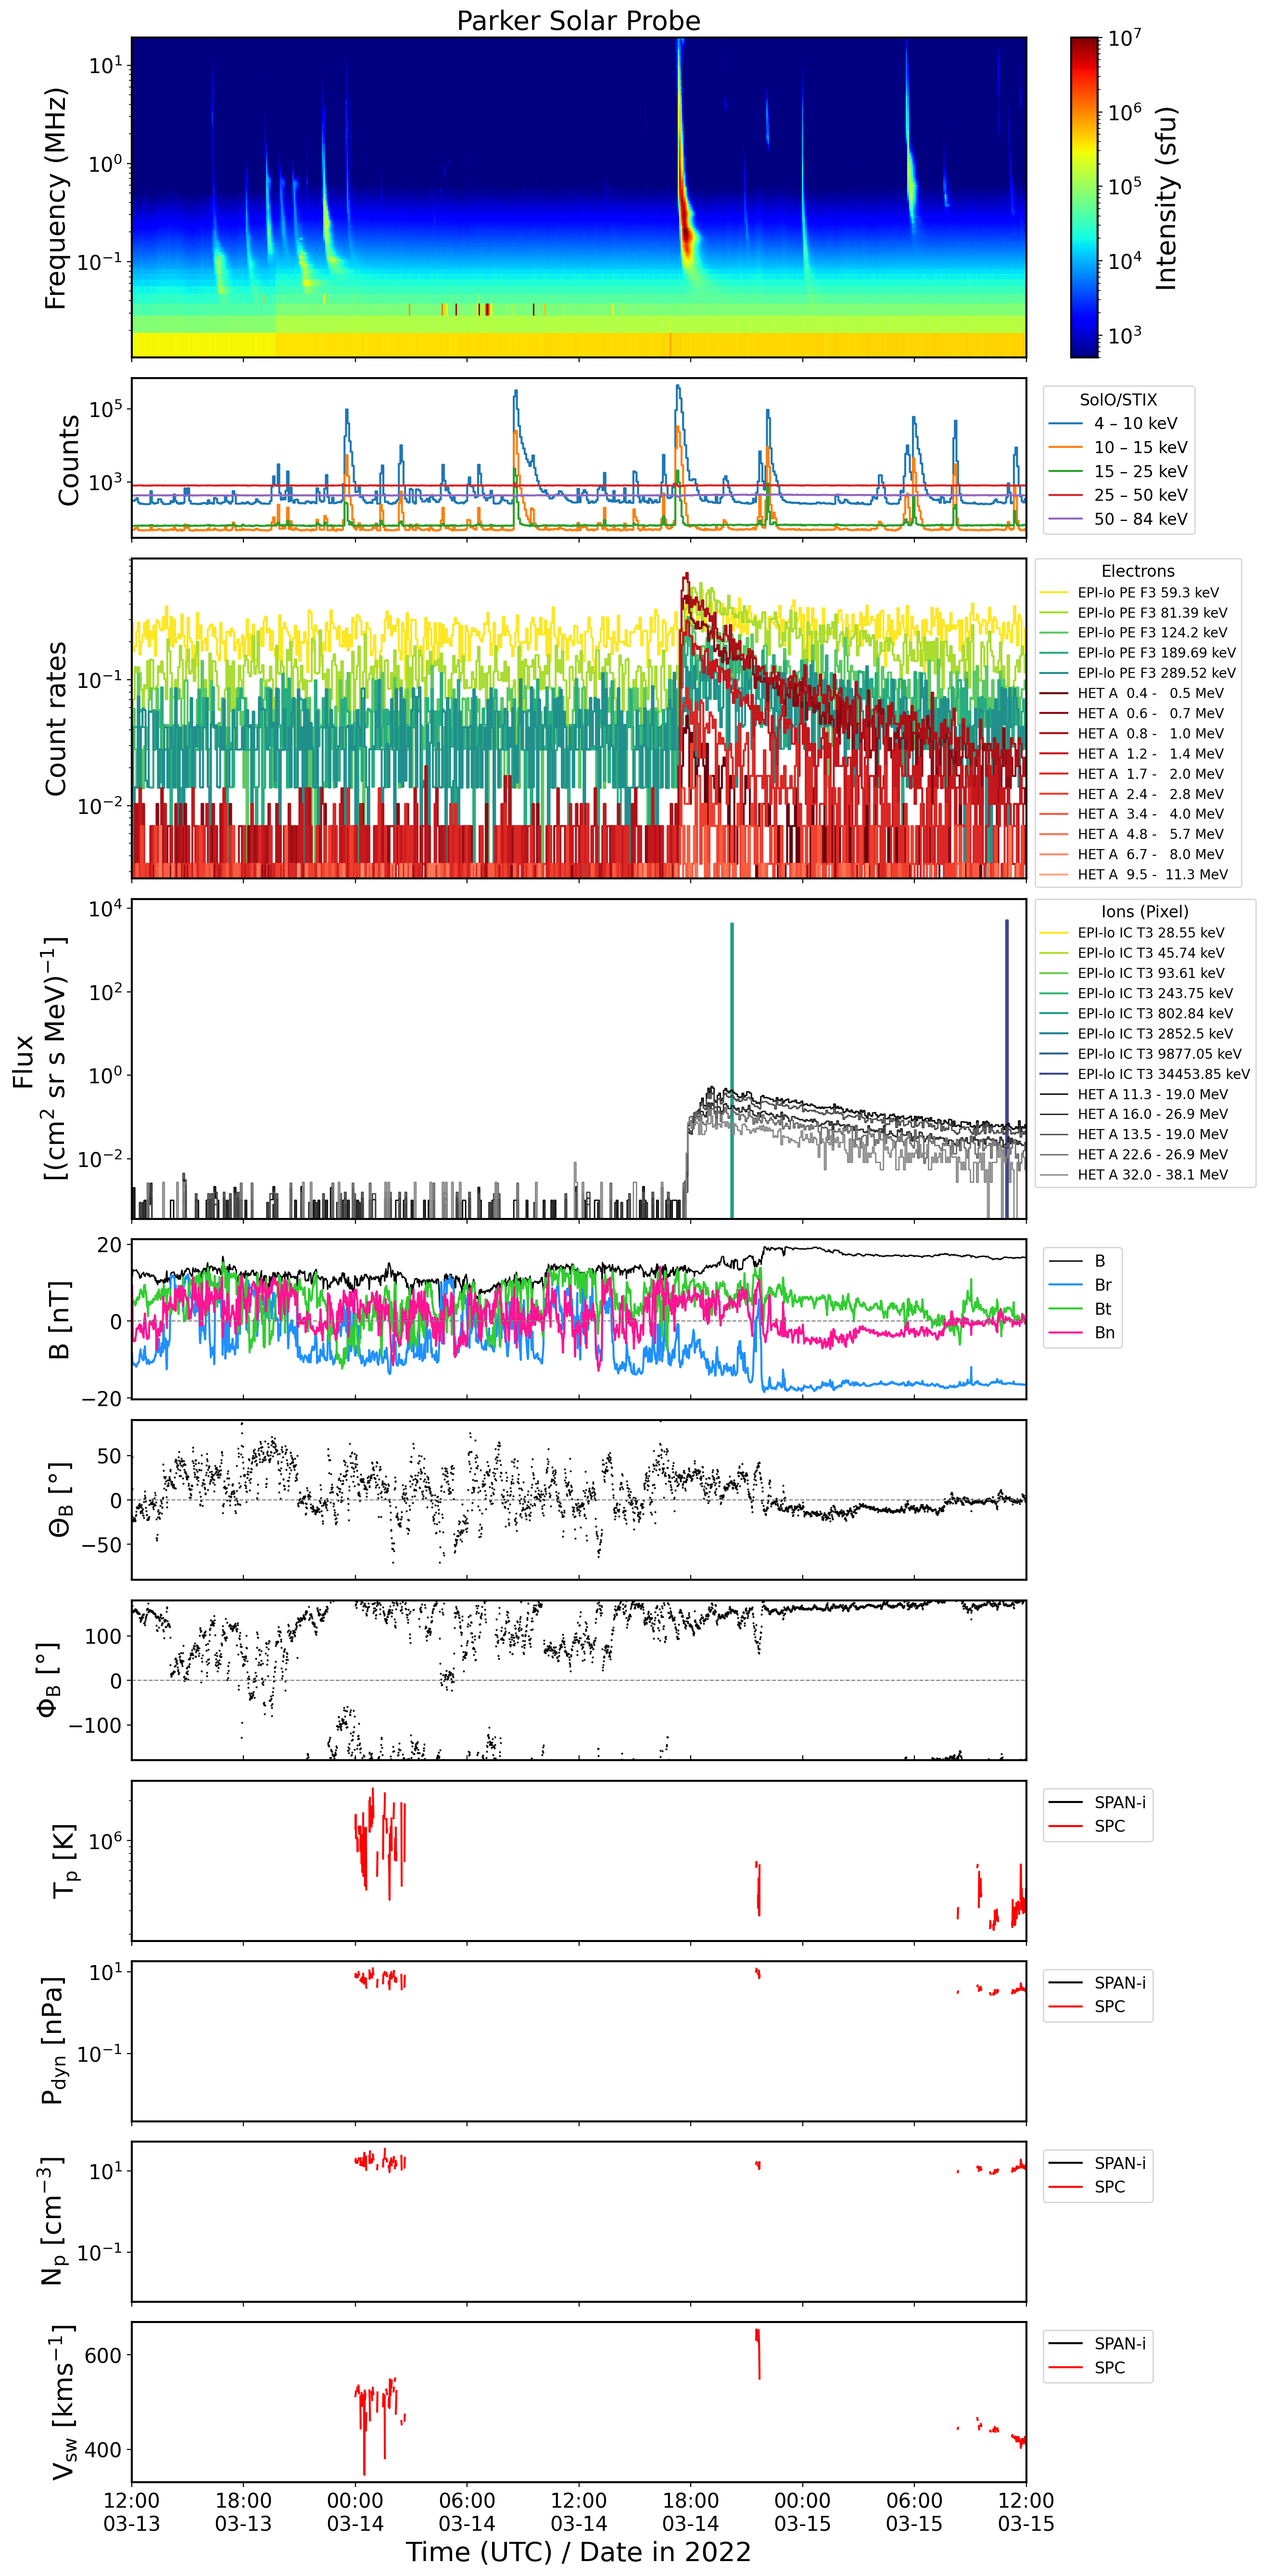

In [68]:
make_plot()

In [69]:
# fig.savefig('figure.png', dpi=200)

## EOF